<span style="color:black; font-size:30px">Weather Visualization (Daily Data)</span>

<span style="color:black; font-size:20px">Import Libraies</span>

<span style="color:black; font-size:12px">This project uses the Visual Crossing Weather API</span>

<span style="color:black; font-size:10px">https://www.visualcrossing.com/</span>

In [21]:
import requests
import matplotlib.pyplot as plt
import json
import csv
import os
import pandas as pd

<span style="color:black; font-size:20px">Calling the API (For 1 Day Data)</span>

<span style="color:black; font-size:15px">Enter the location and the state (For Example: Dallas, TX).</span>

<span style="color:black; font-size:15px">Enter the start and end date for the respective weather data for the day</span>

<span style="color:black; font-size:15px">Use the format YYYY-MM-DD. Be sure to include the hyphen (For Example: 2024-09-22).</span>

In [61]:
token = "Q4LEY2GWSPRKGJG9ANUK39ER2"

location = str(input("Enter location: "))
startDate = str(input("Enter start date (YYYY-MM-DD): "))
endDate = str(input("Enter end date (YYYY-MM-DD): "))

endpoint = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{startDate}/{endDate}?key={token}"

headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json"
}

try:
    response = requests.get(endpoint, headers = headers)
    
    if response.status_code == 200:
        data = response.json() #data retrieved from the api will be stored here
        print("Successfully retrieved the data")
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        print("Response content:", response.text)

except requests.RequestException as e:
    print(f"An error occurred: {e}")

Enter location: Arlington, TX
Enter start date (YYYY-MM-DD): 2024-09-01
Enter end date (YYYY-MM-DD): 2024-09-14
Failed to retrieve data. Status code: 429
Response content: You have exceeded the maximum number of daily result records for your account. Please add a credit card to continue retrieving results.


<span style="color:black; font-size:20px">Export the data to a CSV file</span>

In [82]:
daily = data["days"] #list with dictionaries inside

for day_dict in data["days"]: #removes the unwanted hourly data
    if "hours" in day_dict:
        del day_dict["hours"]
headers = daily[0].keys()

folder = "dataDailyCSV"

if not os.path.exists(folder):
    os.makedirs(folder)

csvFilename = os.path.join(folder, f"{startDate}_to_{endDate}.csv")

with open(csvFilename, 'w', newline = '') as file:
    writer = csv.DictWriter(file, fieldnames = headers)
    writer.writeheader()
    writer.writerows(daily)

<span style="color:black; font-size:20px">Clean the Data</span>

<span style="color:black; font-size:15px">DO NOT RUN if you want all the data.This project aims to correlate weather patterns with solar panel electricity generation.</span>

In [ ]:
cleanedData = pd.read_csv(csvFilename)
cleanedData = cleanedData.drop(columns = ["datetimeEpoch" , "tempmax" , "tempmin" , "temp" , "feelslikemax" , "feelslikemin" , "feelslike" , "dew" , "humidity" , "precip" , "precipprob" , "precipcover" , "preciptype" , "snow" , "snowdepth" , "windgust" , "windspeed" , "winddir" , "pressure" , "visibility" , "severerisk" , "sunrise" , "sunriseEpoch" , "sunset" , "sunsetEpoch" , "moonphase" , "conditions" , "description" , "icon" , "stations" , "source"])
cleanedData.columns = ['Date' , 'Cloud Cover (%)' , 'Solar Irradiance (W/m2)' , 'Solar Energy (MJ/m2)' , 'UV Index']

cleanedData.to_csv(csvFilename , index = False)

<span style="color:black; font-size:20px">Concatenate two CSV Files (Optional)</span>

<span style="color:black; font-size:15px">Concatenate two CSV files to make the dataset larger</span>

In [113]:
def get_valid_filename(prompt):
    while True:
        file_name = input(prompt).strip()
        if '_to_' in file_name:
            return file_name
        else:
            print("Error: Filename must contain '_to_'. Please try again.")

fileName1 = get_valid_filename("Enter File Name 1: ")
newName1 = fileName1.split('_to_')[0]

fileName2 = get_valid_filename("Enter File Name 2: ")
newName2 = fileName2.split('_to_')[1]

filePath1 = os.path.join(folder, f"{fileName1}.csv")
filePath2 = os.path.join(folder, f"{fileName2}.csv")

try:
    if not os.path.isfile(filePath1):
        raise FileNotFoundError(f"File '{filePath1}' does not exist.")
    
    if not os.path.isfile(filePath2):
        raise FileNotFoundError(f"File '{filePath2}' does not exist.")
    
    weatherData1 = pd.read_csv(os.path.join(folder, f"{fileName1}.csv"))
    weatherData2 = pd.read_csv(os.path.join(folder, f"{fileName2}.csv") , header = 0)

    newWeatherData = pd.concat([weatherData1, weatherData2], ignore_index=True)

    csvFilename = os.path.join(folder, f"{newName1}_to_{newName2}.csv")
    newWeatherData.to_csv(csvFilename, index=False)
    
    print(f"Successfully saved combined data to '{csvFilename}'.")

except FileNotFoundError as e:
    print(e)
except pd.errors.EmptyDataError:
    print("Error: One of the files is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

Enter File Name 1: 2024-09-01_to_2024-09-14
Enter File Name 2: 2024-09-15_to_2024-09-22
Successfully saved combined data to 'dataDailyCSV\2024-09-01_to_2024-09-22.csv'.


<span style="color:black; font-size:20px">Visualize the Data</span>

In [114]:
plottingData = pd.read_csv(csvFilename)
rawTime = plottingData['Date']
time_x = [time[5:] for time in rawTime] #removes the seconds from the string
plt.style.use('seaborn-v0_8-darkgrid')

In [115]:
solarIrradiance_y = plottingData['Solar Irradiance (W/m2)']

def solarIrradiance(ax):
    ax.plot(time_x , solarIrradiance_y, color = 'red')
    ax.tick_params(axis='x', rotation=45 , labelsize = 8)
    ax.set_title('Solar Irradiance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Solar Irradiance (W/m2)')

In [116]:
solarEnergy_y = plottingData['Solar Energy (MJ/m2)']

def solarEnergy(ax):
    ax.plot(time_x , solarEnergy_y, color = 'green')
    ax.tick_params(axis='x', rotation=45 , labelsize = 8)
    ax.set_title('Solar Energy')
    ax.set_xlabel('Date')
    ax.set_ylabel('Solar Energy (MJ/m2)')

In [117]:
uvIndex_y = plottingData['UV Index']

def uvIndex(ax):
    ax.plot(time_x , uvIndex_y, color = 'purple')
    ax.tick_params(axis='x', rotation=45 , labelsize = 8)
    ax.set_title('UV Index')
    ax.set_xlabel('Date')
    ax.set_ylabel('UV Index')

In [118]:
cloudCover_y = plottingData['Cloud Cover (%)']

def cloudCover(ax):
    ax.plot(time_x , cloudCover_y, color = 'black')
    ax.tick_params(axis='x', rotation=45 , labelsize = 8)
    ax.set_title('Cloud Cover')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cloud Cover (%)')

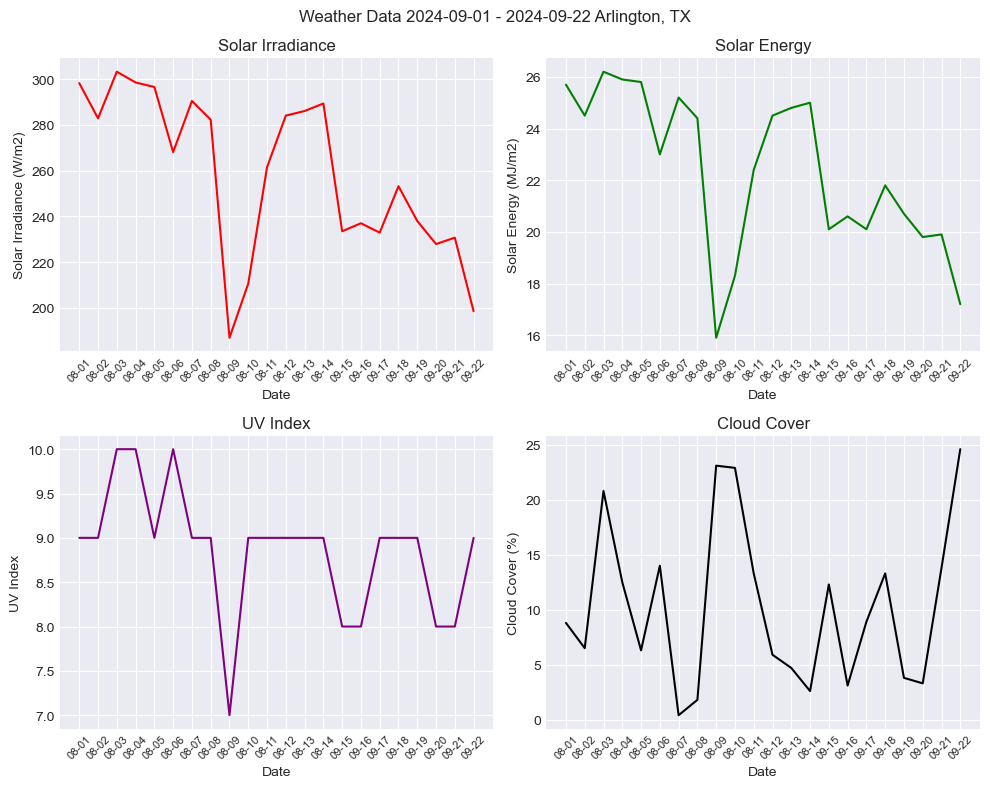

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

solarIrradiance(axes[0, 0])
solarEnergy(axes[0, 1])
uvIndex(axes[1, 0])
cloudCover(axes[1, 1])

titleName1 = newName1 if newName1 else startDate #in the event that the concatenation block isn't executed
titleName2 = newName2 if newName2 else endDate
fig.suptitle(f"Weather Data {titleName1} - {titleName2} {location}")

plt.tight_layout()

plt.show()